<a href="https://colab.research.google.com/github/ThousandAI/Application-of-AI/blob/main/class05/Inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Inception From Scratch**


## Cifar10

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Hyper-parameters 
num_epochs = 10
batch_size = 64
learning_rate = 1e-4 #0.0001

In [4]:
transform = transforms.Compose(
    [ transforms.Resize([224,224]),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
iterator = iter(train_loader)
images,labels = next(iterator)
print(images.shape, labels.shape)

torch.Size([64, 3, 224, 224]) torch.Size([64])


In [6]:
def show(img):
  img = img / 2 + 0.5  # unnormalize
  npimg = img.numpy()
  return np.transpose(npimg, (1, 2, 0))

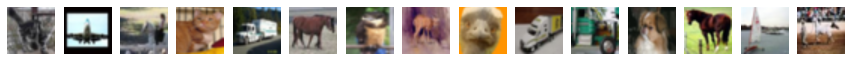

In [7]:
fig, axes = plt.subplots(1,15, figsize=(15, 15))
for i in range(15):
  axes[i].imshow(show(images[i]))
  axes[i].set_axis_off()
fig.show()

## Inception from scratch

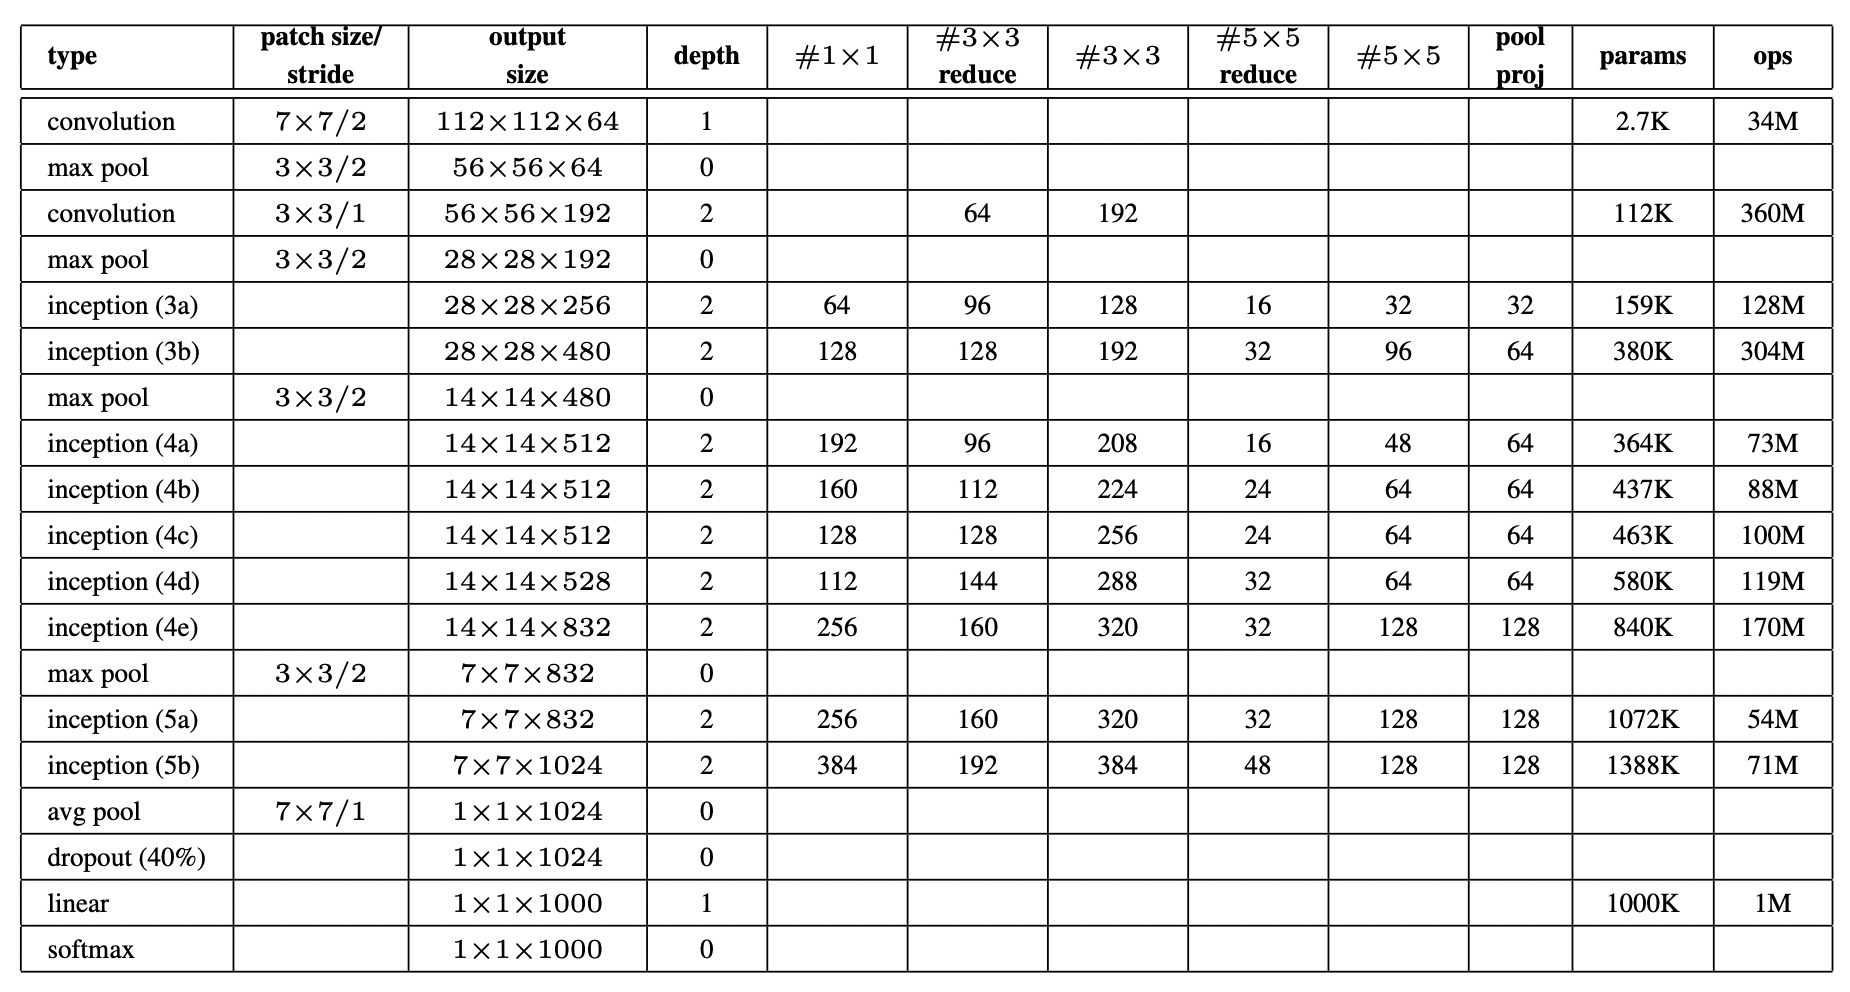

In [8]:
class Inception(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super().__init__()

        self.conv1 = conv_block(in_channels=in_channels, out_channels=64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))

        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = conv_block(64, 192, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # In this order: in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
        self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1)

        self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(1024, num_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc1(x)

        return x
      
class Inception_block(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool):
        super(Inception_block, self).__init__()
        self.branch1 = conv_block(in_channels, out_1x1, kernel_size=(1, 1))

        self.branch2 = nn.Sequential(
            conv_block(in_channels, red_3x3, kernel_size=(1, 1)),
            conv_block(red_3x3, out_3x3, kernel_size=(3, 3), padding=(1, 1)),
        )

        self.branch3 = nn.Sequential(
            conv_block(in_channels, red_5x5, kernel_size=(1, 1)),
            conv_block(red_5x5, out_5x5, kernel_size=(5, 5), padding=(2, 2)),
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            conv_block(in_channels, out_1x1pool, kernel_size=(1, 1)),
        )

    def forward(self, x):
        # N x filter x 224 x 224
        return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)


class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        return self.relu(self.batchnorm(self.conv(x)))

In [9]:
inception = Inception().to(device)

In [10]:
print(inception)

Inception(
  (conv1): conv_block(
    (relu): ReLU()
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): conv_block(
    (relu): ReLU()
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (inception3a): Inception_block(
    (branch1): conv_block(
      (relu): ReLU()
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch2): Sequential(
      (0): conv_block(
        (relu): ReLU()
        (conv): Conv2d(192, 96, kernel_size

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(inception.parameters(), lr=learning_rate)

In [12]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [13]:
count_parameters(inception)

5994074

In [14]:
n_total_steps = len(train_loader)
for epoch in tqdm(range(num_epochs)):
  for i, (images, labels) in enumerate(train_loader):
    # origin shape: [64, 3, 224, 224]
    images = images.to(device)
    labels = labels.to(device)
    # Forward pass
    outputs = inception(images)
    loss = criterion(outputs, labels)
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 100 == 0:
        print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Step [100/782], Loss: 1.4307
Epoch [1/10], Step [200/782], Loss: 1.2770
Epoch [1/10], Step [300/782], Loss: 1.2760
Epoch [1/10], Step [400/782], Loss: 1.3207
Epoch [1/10], Step [500/782], Loss: 0.9383
Epoch [1/10], Step [600/782], Loss: 1.0127
Epoch [1/10], Step [700/782], Loss: 0.8734


 10%|█         | 1/10 [03:18<29:49, 198.88s/it]

Epoch [2/10], Step [100/782], Loss: 0.8937
Epoch [2/10], Step [200/782], Loss: 0.7951
Epoch [2/10], Step [300/782], Loss: 0.6969
Epoch [2/10], Step [400/782], Loss: 0.5470
Epoch [2/10], Step [500/782], Loss: 0.6160
Epoch [2/10], Step [600/782], Loss: 0.8993
Epoch [2/10], Step [700/782], Loss: 0.6331


 20%|██        | 2/10 [06:30<25:55, 194.38s/it]

Epoch [3/10], Step [100/782], Loss: 0.3848
Epoch [3/10], Step [200/782], Loss: 0.7037
Epoch [3/10], Step [300/782], Loss: 0.6642
Epoch [3/10], Step [400/782], Loss: 0.6694
Epoch [3/10], Step [500/782], Loss: 0.5296
Epoch [3/10], Step [600/782], Loss: 0.4776
Epoch [3/10], Step [700/782], Loss: 0.3824


 30%|███       | 3/10 [09:41<22:30, 192.91s/it]

Epoch [4/10], Step [100/782], Loss: 0.3202
Epoch [4/10], Step [200/782], Loss: 0.4685
Epoch [4/10], Step [300/782], Loss: 0.2794
Epoch [4/10], Step [400/782], Loss: 0.5716
Epoch [4/10], Step [500/782], Loss: 0.4856
Epoch [4/10], Step [600/782], Loss: 0.3768
Epoch [4/10], Step [700/782], Loss: 0.5816


 40%|████      | 4/10 [12:52<19:13, 192.20s/it]

Epoch [5/10], Step [100/782], Loss: 0.3207
Epoch [5/10], Step [200/782], Loss: 0.2224
Epoch [5/10], Step [300/782], Loss: 0.2180
Epoch [5/10], Step [400/782], Loss: 0.3743
Epoch [5/10], Step [500/782], Loss: 0.3080
Epoch [5/10], Step [600/782], Loss: 0.2838
Epoch [5/10], Step [700/782], Loss: 0.2781


 50%|█████     | 5/10 [16:03<15:58, 191.73s/it]

Epoch [6/10], Step [100/782], Loss: 0.0914
Epoch [6/10], Step [200/782], Loss: 0.2165
Epoch [6/10], Step [300/782], Loss: 0.2531
Epoch [6/10], Step [400/782], Loss: 0.2811
Epoch [6/10], Step [500/782], Loss: 0.1417
Epoch [6/10], Step [600/782], Loss: 0.2165
Epoch [6/10], Step [700/782], Loss: 0.1389


 60%|██████    | 6/10 [19:14<12:46, 191.55s/it]

Epoch [7/10], Step [100/782], Loss: 0.3496
Epoch [7/10], Step [200/782], Loss: 0.0960
Epoch [7/10], Step [300/782], Loss: 0.2240
Epoch [7/10], Step [400/782], Loss: 0.1850
Epoch [7/10], Step [500/782], Loss: 0.1330
Epoch [7/10], Step [600/782], Loss: 0.1442
Epoch [7/10], Step [700/782], Loss: 0.2931


 70%|███████   | 7/10 [22:25<09:34, 191.49s/it]

Epoch [8/10], Step [100/782], Loss: 0.1483
Epoch [8/10], Step [200/782], Loss: 0.0896
Epoch [8/10], Step [300/782], Loss: 0.1423
Epoch [8/10], Step [400/782], Loss: 0.1046
Epoch [8/10], Step [500/782], Loss: 0.2815
Epoch [8/10], Step [600/782], Loss: 0.2691
Epoch [8/10], Step [700/782], Loss: 0.2796


 80%|████████  | 8/10 [25:36<06:22, 191.29s/it]

Epoch [9/10], Step [100/782], Loss: 0.1327
Epoch [9/10], Step [200/782], Loss: 0.0645
Epoch [9/10], Step [300/782], Loss: 0.0752
Epoch [9/10], Step [400/782], Loss: 0.1513
Epoch [9/10], Step [500/782], Loss: 0.1184
Epoch [9/10], Step [600/782], Loss: 0.2883
Epoch [9/10], Step [700/782], Loss: 0.1212


 90%|█████████ | 9/10 [28:47<03:11, 191.17s/it]

Epoch [10/10], Step [100/782], Loss: 0.0588
Epoch [10/10], Step [200/782], Loss: 0.1474
Epoch [10/10], Step [300/782], Loss: 0.0343
Epoch [10/10], Step [400/782], Loss: 0.1223
Epoch [10/10], Step [500/782], Loss: 0.1503
Epoch [10/10], Step [600/782], Loss: 0.0890
Epoch [10/10], Step [700/782], Loss: 0.1194


100%|██████████| 10/10 [31:58<00:00, 191.84s/it]


In [15]:
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(10)]
  n_class_samples = [0 for i in range(10)]
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = inception(images)
    # max returns (value ,index)
    _, predicted = torch.max(outputs, 1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()

  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network: {acc} %')

Accuracy of the network: 84.94 %
